In [1]:
#  Análise Exploratória - E-commerce
# Autor: Wagner Pontes
# Objetivo: Explorar dados de vendas, logística e satisfação do cliente


In [2]:
# Importação das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [5]:
import os
import pandas as pd

BASE = os.path.abspath(os.path.join(os.getcwd(), ".."))  # volta 1 nível (notebooks -> projeto)
RAW = os.path.join(BASE, "dados", "raw")

arquivos = {
    "pedidos": "pedidos.csv",
    "itens_pedido": "itens_pedido.csv",
    "clientes": "clientes.csv",
    "produtos": "produtos.csv",
    "avaliacoes": "avaliacoes.csv",
    "pagamentos": "pagamentos.csv",
    "categorias_produtos": "categorias_produtos.csv",
}

dfs = {}

for nome, arq in arquivos.items():
    caminho = os.path.join(RAW, arq)
    if os.path.exists(caminho):
        dfs[nome] = pd.read_csv(caminho)
        print(f"✅ {nome}: {dfs[nome].shape}")
    else:
        print(f"⚠️ Não achei: {caminho}")

✅ pedidos: (99441, 8)
✅ itens_pedido: (112650, 7)
✅ clientes: (99441, 5)
✅ produtos: (32951, 9)
✅ avaliacoes: (99224, 7)
✅ pagamentos: (103886, 5)
✅ categorias_produtos: (71, 2)


In [6]:
import os
import pandas as pd

BASE = os.path.abspath(os.path.join(os.getcwd(), ".."))
RAW = os.path.join(BASE, "dados", "raw")

print("Pasta RAW:", RAW)

for f in os.listdir(RAW):
    print(f)

Pasta RAW: C:\Analise_ecommerce_PowerBI\dados\raw
avaliacoes.csv
categorias_produtos.csv
clientes.csv
geolocalizacao.csv
itens_pedido.csv
pagamentos.csv
pedidos.csv
produtos.csv
vendedores.csv


In [7]:
pedidos = pd.read_csv(os.path.join(RAW, "pedidos.csv"))
itens = pd.read_csv(os.path.join(RAW, "itens_pedido.csv"))
clientes = pd.read_csv(os.path.join(RAW, "clientes.csv"))
produtos = pd.read_csv(os.path.join(RAW, "produtos.csv"))
avaliacoes = pd.read_csv(os.path.join(RAW, "avaliacoes.csv"))

print(pedidos.shape)
print(itens.shape)
print(clientes.shape)
print(produtos.shape)
print(avaliacoes.shape)

(99441, 8)
(112650, 7)
(99441, 5)
(32951, 9)
(99224, 7)


In [9]:
pedidos.columns.tolist()

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [10]:
import os
import numpy as np
import pandas as pd

# 1) Renomear colunas para PT-BR (pedidos)
map_pedidos = {
    "order_id": "id_pedido",
    "customer_id": "id_cliente",
    "order_status": "status_pedido",
    "order_purchase_timestamp": "data_compra",
    "order_approved_at": "data_aprovacao",
    "order_delivered_carrier_date": "data_envio",
    "order_delivered_customer_date": "data_entrega",
    "order_estimated_delivery_date": "data_estimada",
}
pedidos = pedidos.rename(columns=map_pedidos)

# 2) Converter datas
cols_data = ["data_compra", "data_aprovacao", "data_envio", "data_entrega", "data_estimada"]
for c in cols_data:
    pedidos[c] = pd.to_datetime(pedidos[c], errors="coerce")

# 3) Criar tempo de entrega e atraso
pedidos["tempo_entrega_dias"] = (pedidos["data_entrega"] - pedidos["data_compra"]).dt.days
pedidos["atrasou"] = pedidos["data_entrega"] > pedidos["data_estimada"]

# 4) Filtrar entregues e limpar valores impossíveis
pedidos_entregues = pedidos[
    (pedidos["status_pedido"] == "delivered") &  # aqui ainda é o valor original do Kaggle
    (pedidos["tempo_entrega_dias"].notna()) &
    (pedidos["tempo_entrega_dias"] >= 0)
].copy()

# remover outliers absurdos (recomendado p/ análise)
pedidos_entregues = pedidos_entregues[pedidos_entregues["tempo_entrega_dias"] <= 90].copy()

print("✅ pedidos_entregues:", pedidos_entregues.shape)
print(pedidos_entregues["tempo_entrega_dias"].describe())

✅ pedidos_entregues: (96394, 10)
count    96394.000000
mean        11.995664
std          8.839906
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         90.000000
Name: tempo_entrega_dias, dtype: float64


In [11]:
avaliacoes.columns.tolist()

['review_id',
 'order_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp']

In [12]:
# 5) Renomear colunas (avaliacoes)
map_avaliacoes = {
    "order_id": "id_pedido",
    "review_score": "nota_avaliacao",
    "review_creation_date": "data_avaliacao",
}
avaliacoes_ren = avaliacoes.rename(columns=map_avaliacoes).copy()

# converter data de avaliação
if "data_avaliacao" in avaliacoes_ren.columns:
    avaliacoes_ren["data_avaliacao"] = pd.to_datetime(avaliacoes_ren["data_avaliacao"], errors="coerce")

# 6) Garantir 1 avaliação por pedido (pegar a última por data)
avaliacoes_1 = (
    avaliacoes_ren.sort_values("data_avaliacao")
    .drop_duplicates(subset=["id_pedido"], keep="last")
)

# 7) Juntar avaliação nos pedidos entregues
base_logistica = pedidos_entregues.merge(
    avaliacoes_1[["id_pedido", "nota_avaliacao"]],
    on="id_pedido",
    how="left"
)

# 8) Criar faixa de entrega
def faixa_entrega(d):
    if pd.isna(d):
        return np.nan
    if d <= 7:
        return "0-7"
    elif d <= 15:
        return "8-15"
    elif d <= 30:
        return "16-30"
    else:
        return "30+"

base_logistica["faixa_entrega"] = base_logistica["tempo_entrega_dias"].apply(faixa_entrega)

print("✅ base_logistica:", base_logistica.shape)
print(base_logistica[["tempo_entrega_dias", "nota_avaliacao"]].describe())
print("\nDistribuição faixa_entrega:")
print(base_logistica["faixa_entrega"].value_counts(dropna=False))

# 9) Salvar dataset processado
BASE = os.path.abspath(os.path.join(os.getcwd(), ".."))
PROCESSED = os.path.join(BASE, "dados", "processed")
os.makedirs(PROCESSED, exist_ok=True)

saida = os.path.join(PROCESSED, "base_logistica.csv")
base_logistica.to_csv(saida, index=False)
print("\n✅ Salvo em:", saida)

✅ base_logistica: (96394, 12)
       tempo_entrega_dias  nota_avaliacao
count        96394.000000    95752.000000
mean            11.995664        4.156770
std              8.839906        1.283973
min              0.000000        1.000000
25%              6.000000        4.000000
50%             10.000000        5.000000
75%             15.000000        5.000000
max             90.000000        5.000000

Distribuição faixa_entrega:
faixa_entrega
8-15     39567
0-7      33696
16-30    19090
30+       4041
Name: count, dtype: int64

✅ Salvo em: C:\Analise_ecommerce_PowerBI\dados\processed\base_logistica.csv


In [15]:
corr = base_logistica[["tempo_entrega_dias", "nota_avaliacao"]].corr()
corr

,tempo_entrega_dias,nota_avaliacao
tempo_entrega_dias,1.000000,-0.349735
nota_avaliacao,-0.349735,1.000000


In [16]:
tempo_por_nota = base_logistica.groupby("nota_avaliacao")["tempo_entrega_dias"].mean()
tempo_por_nota

nota_avaliacao
1.0    20.520004
2.0    15.980110
3.0    13.705258
4.0    11.727711
5.0    10.178443
Name: tempo_entrega_dias, dtype: float64

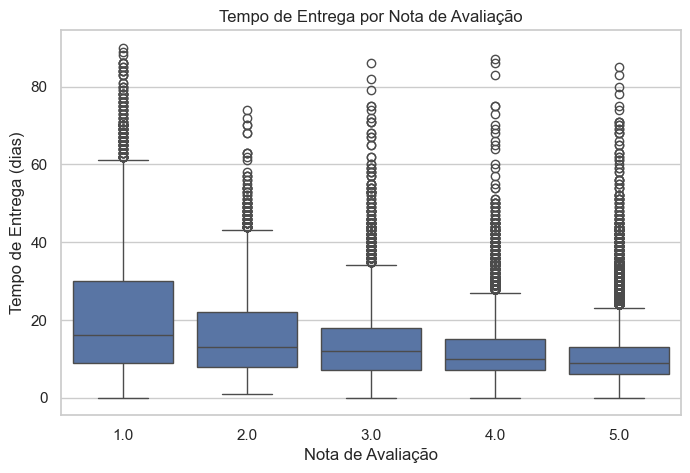

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=base_logistica, x="nota_avaliacao", y="tempo_entrega_dias")
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Tempo de Entrega (dias)")
plt.show()

In [19]:
percentual_atraso = base_logistica["atrasou"].mean() * 100
percentual_atraso

np.float64(8.039919497064133)

In [20]:
nota_por_atraso = base_logistica.groupby("atrasou")["nota_avaliacao"].mean()
nota_por_atraso

atrasou
False    4.294001
True     2.562525
Name: nota_avaliacao, dtype: float64